## CV Project -Face Mask Segmentation
The Problem Description:
The goal is to build a Face Mask Segmentation model which includes building a face detector to locate the position of a face in an image . We use "Transfer Learning" of an Image Segmentation model to detect any object

### Data Description:
WIDER FACE dataset is a Face Mask Segmentation benchmark dataset, of which images are selected from the publicly available WIDER dataset. This data have 32,203 images and 393,703 faces are labeled with a high degree of variability in scale, pose and occlusion as depicted in the sample images. In this project, we are using 409 images and around 1000 faces for ease of computation.

### Objective:
In this problem, we are particularly interested in segmenting faces in a given image

### Steps and Tasks:
● Load the dataset given in form .npy format.

○ We have already extracted the images from wider face-dataset and added it in the file images.npy. You can directly use this file for this project.

○ “images.npy” contains details about the image and it’s masks, there is no separate CSV file for that

○ There is no separate train and test data given

● Create Features(images) and labels(mask) using that data.

● Load the pre-trained model and weights.

● Create a model using the above model.

● Define the Dice Coefficient and Loss function.

● Compile and fit the model.

● Evaluate the model.

### Mounting The Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
path = '.'

### Loading the libraries

In [0]:
from __future__ import absolute_import
from __future__ import print_function
import os
import time
from datetime import timedelta
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import keras
import keras.callbacks
from keras.callbacks import TensorBoard
import pandas.util.testing as tm

In [5]:
print(tf.__version__)

2.2.0


### Loading and checking the Dataset

In [0]:
data = np.load('images.npy',allow_pickle=True)

In [7]:
print (data[15][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.26266666666666666, 'y': 0.08266666666666667}, {'x': 0.3973333333333333, 'y': 0.3893333333333333}], 'imageWidth': 750, 'imageHeight': 375}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.49866666666666665, 'y': 0.050666666666666665}, {'x': 0.5973333333333334, 'y': 0.2613333333333333}], 'imageWidth': 750, 'imageHeight': 375}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.6773333333333333, 'y': 0.112}, {'x': 0.7906666666666666, 'y': 0.368}], 'imageWidth': 750, 'imageHeight': 375}]


In [8]:
data.shape

(409, 2)

### Check one sample from the loaded "images.npy" file

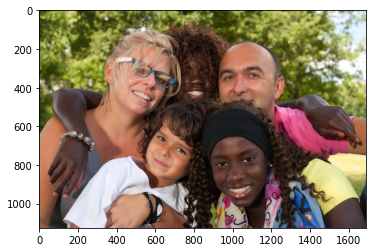

In [9]:
from matplotlib import pyplot as plt
plt.imshow(data[208][0])
plt.show()

### Set image dimensions

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
Here feature is the image

The label is the mask

Images will be stored in "X_train" array

Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array

In [12]:
#Check the data
print(X_train.shape)
print(masks.shape)

(409, 224, 224, 3)
(409, 224, 224)


### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  ...
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]]

 [[-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  ...
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]]

 [[-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  ...
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]]

 ...

 [[-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]
  ...
  [-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]]

 [

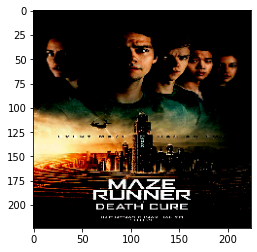

In [13]:
from matplotlib import pyplot
n = 11
print(X_train[n])
pyplot.imshow(X_train[n])

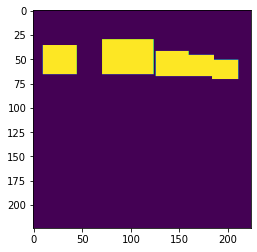

In [14]:
pyplot.imshow(masks[n])

### Create the model
Add MobileNet as model with below parameter values

input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3

include_top: False alpha : 1.0 Weights: Imagenet

### Add UNET architecture layers

In [0]:
from keras.applications import MobileNet
from keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from keras.models import Model
import math
import cv2
import csv

from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),alpha=1.0, include_top=False, weights='imagenet')

    for layer in model.layers:
        layer.trainable = trainable

    B1=model.get_layer("conv_pw_1_relu").output 
    B2=model.get_layer("conv_pw_3_relu").output 
    B3=model.get_layer("conv_pw_5_relu").output 
    B4=model.get_layer("conv_pw_11_relu").output 
    B5=model.get_layer("conv_pw_13_relu").output 

    x = Concatenate()([UpSampling2D()(B5),B4]) #14x14
    x = Concatenate()([UpSampling2D()(x),B3])  #28x28
    x = Concatenate()([UpSampling2D()(x),B2])  #56x56
    x = Concatenate()([UpSampling2D()(x),B1])  #112x112
    x = UpSampling2D()(x) #224x224

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Create the Model

In [16]:
model = create_model()

model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
___________________________

### Define the Dice Coefficient and Loss function

Create a function to calculate dice coefficient

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
from keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile and fit the model

In [0]:
# compile model
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss=loss, metrics=[dice_coefficient])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
stop = EarlyStopping(monitor='loss', min_delta=0, patience=5, mode="min")

In [21]:
EPOCH = 20
BATCH_SIZE = 1
PATIENCE = 10
THREADS = 1
model.fit(x=X_train,
          y=masks,
          epochs=20,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint, stop],
          workers=THREADS,
          use_multiprocessing=False,
          verbose=1
          )

Epoch 1/20
409/409 [==============================] - 29s 70ms/step - loss: 1.9019 - dice_coefficient: 0.2822
Epoch 2/20
  3/409 [..............................] - ETA: 20s - loss: 1.2471 - dice_coefficient: 0.4761

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


409/409 [==============================] - 22s 53ms/step - loss: 1.3608 - dice_coefficient: 0.3993
Epoch 3/20
409/409 [==============================] - 22s 53ms/step - loss: 1.2181 - dice_coefficient: 0.4477
Epoch 4/20
409/409 [==============================] - 21s 53ms/step - loss: 1.1504 - dice_coefficient: 0.4736
Epoch 5/20
409/409 [==============================] - 22s 53ms/step - loss: 1.1098 - dice_coefficient: 0.4911
Epoch 6/20
409/409 [==============================] - 21s 53ms/step - loss: 1.0819 - dice_coefficient: 0.5021
Epoch 7/20
409/409 [==============================] - 22s 53ms/step - loss: 1.0649 - dice_coefficient: 0.5097
Epoch 8/20
409/409 [==============================] - 22s 53ms/step - loss: 1.0434 - dice_coefficient: 0.5180
Epoch 9/20
409/409 [==============================] - 22s 53ms/step - loss: 1.0312 - dice_coefficient: 0.5226
Epoch 10/20
409/409 [==============================] - 22s 53ms/step - loss: 1.0184 - dice_coefficient: 0.5267
Epoch 11/20
409/409 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


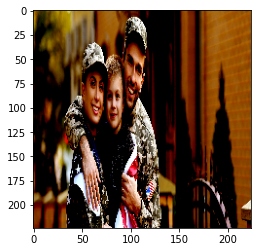

In [22]:
n = 299
sample_image = X_train[n]

plt.imshow(sample_image)
img = np.expand_dims(sample_image, axis=0)
out= model.predict(img)

In [23]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [24]:
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


### Evaluate the model

Impose the mask on the image

ValueError: ignored

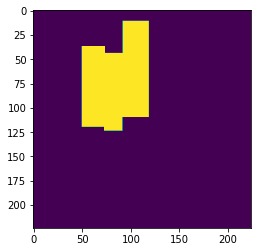

In [25]:
# evaluate loaded model on test data
Final = masks[299]
plt.imshow(Final)
img = np.expand_dims(Final, axis=0)
img = np.expand_dims(Final, axis=0)
predict = model.predict(img)

### Conclusion

The computational model which was implemented in this project, was chosen after successful testing results confirm that the model was reliable.This system was tested under very robust conditions and it is envisaged that real-world performance will be far more accurate.The fully automated frontal view face detection system displayed virtually perfect accuracy.